<a href="https://colab.research.google.com/github/HadiAlizadeh1/mci-chatbot/blob/main/English_TTS_Telegram_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In the name of Allah

### In thia notebook we are going to run Telegram TTS chat bot.
### you can send your text to this bot to give your text voice. 
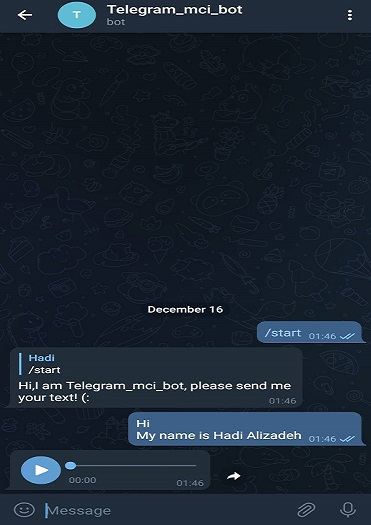




### This notebook requires a GPU runtime to run.
### Please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"

----------------------------------------------------------------------

# Tacotron 2

*Author: NVIDIA*

**The Tacotron 2 model for generating mel spectrograms from text**

<img src="https://pytorch.org/assets/images/tacotron2_diagram.png" alt="alt" width="50%"/>



### Model Description

The Tacotron 2 and WaveGlow model form a text-to-speech system that enables user to synthesise a natural sounding speech from raw transcripts without any additional prosody information. The Tacotron 2 model produces mel spectrograms from input text using encoder-decoder architecture. WaveGlow (also available via torch.hub) is a flow-based model that consumes the mel spectrograms to generate speech.

This implementation of Tacotron 2 model differs from the model described in the paper. Our implementation uses Dropout instead of Zoneout to regularize the LSTM layers.

### Example

In the example below:
- pretrained Tacotron2 and Waveglow models are loaded from torch.hub
- Given a tensor representation of the input text ("Hello world, I missed you so much"), Tacotron2 generates a Mel spectrogram as shown on the illustration
- Waveglow generates sound given the mel spectrogram
- the output sound is saved in an 'audio.wav' file

To run the example you need some extra python packages installed.
These are needed for preprocessing the text and audio, as well as for display and input / output.

## Befor start Get a Telegram Bot Token

1. **Start a chat with BotFather**  
   - Open Telegram and search for **@BotFather** or visit [BotFather](https://t.me/BotFather).

2. **Create a New Bot**  
   - Type the command: `/newbot`  
   - Choose a **name** for your bot (e.g., `My Awesome Bot`).  
   - Choose a **username** (must end with `bot`, e.g., `my_awesome_bot`).

3. **Receive Your Bot Token**  
   - After creating your bot, you will receive a token like this:
     ```
     1234567890:ABCDEFGHIJKLMNOPQRSTUVWXYZ-abcdefghijklmnopqrstuvwxyz
     ```

4. **Use the Token**  
   - To interact with the Telegram API, use the token in URLs like:
     ```
     https://api.telegram.org/bot<Your_Bot_Token>/METHOD_NAME
     ```

5. **Optional: Configure Your Bot**  
   - Additional configuration commands via BotFather:
     - `/setdescription` – Set bot description
     - `/setcommands` – Set bot commands
     - `/setuserpic` – Set bot avatar
     - `/setprivacy` – Set privacy settings


In [1]:
!pip install numpy scipy librosa unidecode inflect librosa
!apt-get update
!apt-get install -y libsndfile1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.n

In [2]:
import torch
tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2', model_math='fp16')
tacotron2 = tacotron2.to('cuda')
tacotron2.eval()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


Tacotron2(
  (embedding): Embedding(148, 512)
  (encoder): Encoder(
    (convolutions): ModuleList(
      (0): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (0): LinearNorm(
          (lin

In [3]:
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp16')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


WaveGlow(
  (upsample): ConvTranspose1d(80, 80, kernel_size=(1024,), stride=(256,))
  (WN): ModuleList(
    (0): WN(
      (in_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
        (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
        (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
        (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
      )
      (res_skip_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
        (1): Conv1d(51

## connect to telegram

In [4]:
! pip install pyTelegramBotAPI

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
TOKEN = ""

In [62]:
import telebot
from scipy.io.wavfile import write

bot = telebot.TeleBot(TOKEN)

@bot.message_handler(commands=['start'])
def send_welcome(message):
	bot.reply_to(message, "Hi,I am Telegram_mci_bot, please send me your text! (:")

@bot.message_handler(func=lambda message: True )
def echo_all(message):
  #values = message.values()
  lst = str(message)
  text = lst.split('text')[2].split(":")[1].split("}")[0].split(',')[0]
  chat_id =int(lst.split(':')[5].split(",")[0])
  print(text)
  utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')
  sequences, lengths = utils.prepare_input_sequence([text])

  with torch.no_grad():
    mel, _, _ = tacotron2.infer(sequences, lengths)
    audio = waveglow.infer(mel)
    audio_numpy = audio[0].data.cpu().numpy()
    rate = 22050
    write("audio.ogg", rate, audio_numpy)
    # sendAudio
    audio = open('/content/audio.ogg', 'rb')
    bot.send_audio(chat_id, audio)
    bot.send_audio(chat_id, "FILEID")
@bot.message_handler(content_types=['document', 'audio'])
def handle_docs_audio(message):

   bot.reply_to(message, audio.ogg)

bot.infinity_polling()

 'Hi\nMy name is Hadi Alizadeh'


Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
2022-12-15 22:23:45,585 (__init__.py:1083 MainThread) ERROR - TeleBot: "Threaded polling exception: A request to the Telegram API was unsuccessful. Error code: 400. Description: Bad Request: wrong remote file identifier specified: Wrong padding in the string"
ERROR:TeleBot:Threaded polling exception: A request to the Telegram API was unsuccessful. Error code: 400. Description: Bad Request: wrong remote file identifier specified: Wrong padding in the string
2022-12-15 22:23:45,593 (__init__.py:1085 MainThread) ERROR - TeleBot: "Exception traceback:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/telebot/__init__.py", line 1074, in __threaded_polling
    self.worker_pool.raise_exceptions()
  File "/usr/local/lib/python3.8/dist-packages/telebot/util.py", line 156, in raise_exceptions
    raise self.exception_info
  File "/usr/local/lib/python3.8/dist-packages/telebot/util.py"

In [63]:
import IPython
IPython.display.Audio('/content/audio.ogg')